# Heart Lung Disease Detection

The purpose of this notebook is to analyze the problem of the heart lung disease detection from a dataset containing lung sound recordings from 112 subjects (35 healthy and 77 unhealthy), with ages ranging from 21 to 90 years old. The recordings are captured using an electronic stethoscope and include sounds from various lung and heart ailments such as asthma, heart failure, pneumonia, bronchitis, pleural effusion, lung fibrosis, and chronic obstructive pulmonary disease (COPD), as well as normal breathing sounds.

This document state the process required by the hiring company (SAMAY) in order to demonstrate the techinal skills in the ML field for the candidate.

## Part 1 

This part concerns a preliminar Exploratory Data Analysis of the provided dataset. Let us answer the requirements as follows:

### How did you load the dataset into your Python environment? 

What libraries were used, and why? Provide a code snippet that verifies the correct loading of the data and displays the first few rows. 

Let us display a comparison between a healthy vs. pathological in their waves.




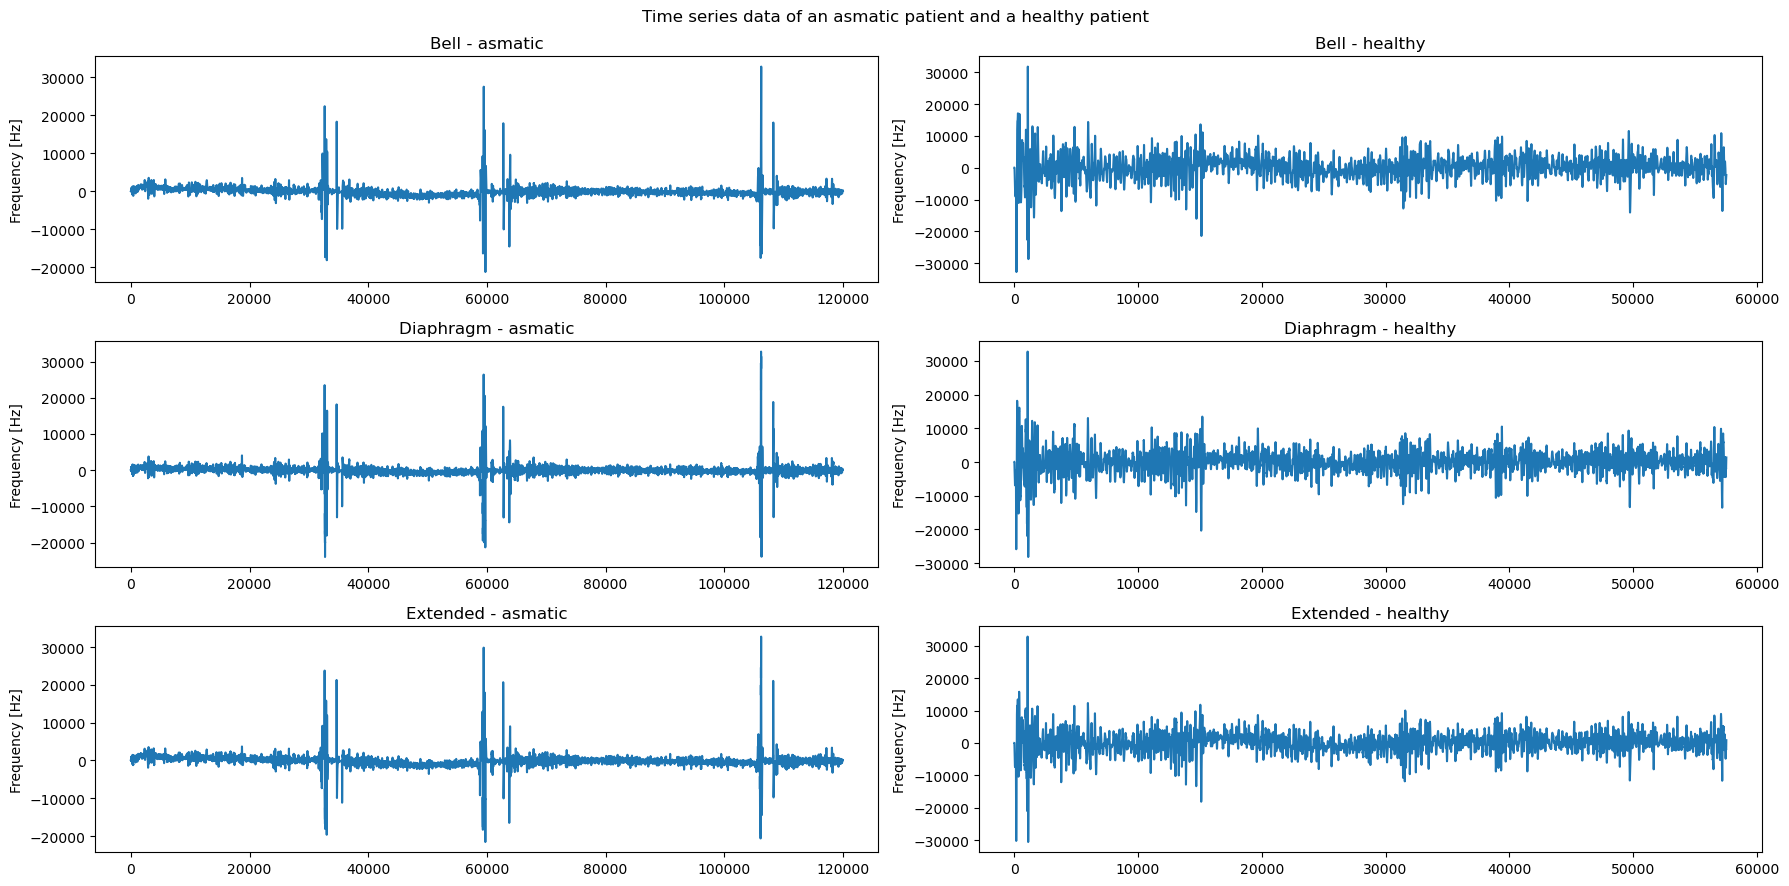

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile

# main path
audio_path = '../dataset/AudioFiles/'
# Reading the wav file
filter_names = {"B": "Bell", "D": "Diaphragm", "E": "Extended"}
colors = {"B": "blue", "D": "green", "E": "red"}
post_fix = {'asmatic': "P1_Asthma,I E W,P L L,70,M.wav", 'healthy': 'P94_N,N,P L L,24,M.wav'}
fig, axs = plt.subplots(3, 2, figsize=(18,9))

for j, subject in enumerate(['asmatic', 'healthy']):
    for i, filter in enumerate(["B", "D", "E"]):
        sample_rate, sample_data = wavfile.read(audio_path + f'{filter}{post_fix[subject]}')
        df_sample = pd.DataFrame(sample_data)
        sns.lineplot(data=df_sample, ax=axs[i, j], legend=False, color=colors[filter])
        axs[i, j].set_title(f'{filter_names[filter]} - {subject}')
        axs[i, j].set_ylabel('Frequency [Hz]') 

fig.suptitle('Time series data of an asmatic patient and a healthy patient')
plt.tight_layout()
plt.show()

We can see notable differences in terms of amplitude between non-pathological and asmatics. From the same dataset, there is also the annotation dataset (metadata) where we can see the labels of each recording:

In [3]:
file_name = '../dataset/Data annotation.xlsx'
df_meta = pd.read_excel(file_name, sheet_name='Sheet1', header=0, usecols="A:E")
df_meta.dropna(inplace=True)
df_meta.sample(5)
df_meta.index.name = "SubjectNo"
df_meta

,Age,Gender,Location,Sound type,Diagnosis
SubjectNo,,,,,
0,70.0,M,P L L,I E W,Asthma
1,52.0,F,P L L,E W,Asthma
2,50.0,F,P L L,I E W,Asthma
3,72.0,F,P R L,I C,Heart Failure + Lung Fibrosis
4,71.0,M,P R L,I C E W,Heart Failure + COPD
...,...,...,...,...,...
107,63.0,M,P R L,E W,COPD
108,26.0,M,P L M,N,N
109,62.0,M,P L L,E W,COPD


In [4]:
print(df_meta.info())

print(f"Data type of the time series {type(sample_data)}, and the datatype of the rate is {type(sample_rate)}")

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         112 non-null    float64
 1   Gender      112 non-null    object 
 2   Location    112 non-null    object 
 3   Sound type  112 non-null    object 
 4   Diagnosis   112 non-null    object 
dtypes: float64(1), object(4)
memory usage: 5.2+ KB
None
Data type of the time series <class 'numpy.ndarray'>, and the datatype of the rate is <class 'int'>


### What is the structure of the dataset and the data types of each column after loading? Are there any columns that require type conversion for further analysis? How would you handle these conversions?

In terms of the audio files, after conversion we have the information from the rate (integer) and an array for the time series data. For the annotations dataset, it is observed that there are four object data types, which can be converted through one-hot encoding to numbers. Let us see the size of each category per column.


In [5]:
count_dict = {}
for column in df_meta.columns[1:]:
    count_dict.update({column: df_meta[column].value_counts()})
count_dict['Diagnosis']


Diagnosis
N                                 35
Asthma                            17
heart failure                     15
asthma                            15
COPD                               8
pneumonia                          5
Lung Fibrosis                      4
Heart Failure                      3
BRON                               3
Heart Failure + COPD               2
Plueral Effusion                   2
Heart Failure + Lung Fibrosis      1
Asthma and lung fibrosis           1
copd                               1
Name: count, dtype: int64

In [6]:
count_dict['Sound type']

Sound type
E W          39
N            35
Crep         23
C             7
I E W         2
I C E W       2
I C B         2
I C           1
Bronchial     1
Name: count, dtype: int64

In [7]:
count_dict['Location']

Location
P R L     24
P L L     16
P R M     16
P R U     14
P L M     12
P L U     11
A R U      6
A R M      4
A R L      4
P L L      3
A L U      2
Name: count, dtype: int64

From the __Diagnosis__ column we can combine the __heart attack__ coincidences, as well as some labels as ["Asthma", "astmha"] or [COPD, copd]

In [8]:
df_meta['Diagnosis'] = df_meta['Diagnosis'].replace(['Heart Failure + COPD', 
                    'Heart Failure + Lung Fibrosis ', 'heart failure'], 'Heart Failure')
df_meta['Diagnosis'] = df_meta['Diagnosis'].replace(['asthma','Asthma and lung fibrosis'], 'Asthma')
df_meta['Diagnosis'] = df_meta['Diagnosis'].replace('copd', 'COPD')
count_dict['Diagnosis'] = df_meta['Diagnosis'].value_counts()
count_dict['Diagnosis']

Diagnosis
N                   35
Asthma              33
Heart Failure       21
COPD                 9
pneumonia            5
Lung Fibrosis        4
BRON                 3
Plueral Effusion     2
Name: count, dtype: int64

### Are there missing or anomalous values in the dataset? Describe the method(s) you used to identify these issues and your approach to handling them.

There are no missing values from now and we have merged the diagnosis categories. It is no observed any other alteration in the metadata. We will need to see the time series in order to determine some outliers. By inspection, It is observed a bias in the age of subjects in the Normal (N) category.

### Generate and interpret the descriptive statistics of the dataset. What insights can you derive from these statistics, and how might they influence your preprocessing steps?

Below we can see that 61.6% of the population is male and 38.39 for female subjects. Moreover, the violinplot show a normal distribution with no outliers in the nominal category.



Gender
M    69
F    43
Name: count, dtype: int64


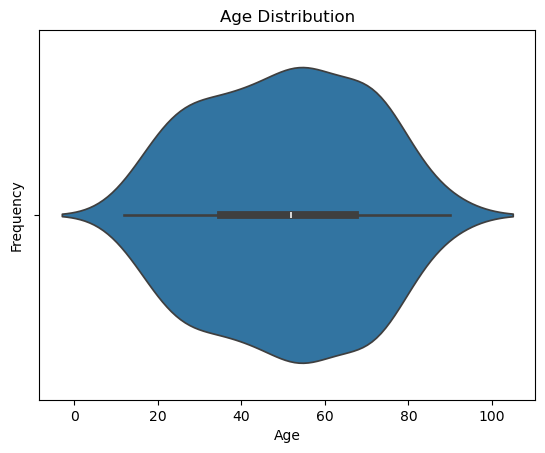

In [9]:
print(count_dict['Gender'])
sns.violinplot(x=df_meta["Age"])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

### Analyze the balance of the dataset across the different conditions (e.g.,asthma, pneumonia). How many recordings are there per condition? Provide a visualization (such as a bar chart) showing the distribution of classes and discuss potential model training challenges due to these distributions.

Below it is depicted the corresponding distributions of the categories

/tmp/ipykernel_1543678/1151014312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
/tmp/ipykernel_1543678/1151014312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
/tmp/ipykernel_1543678/1151014312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
/tmp/ipykernel_1543678/1151014312.py:4: FutureWarning: 

Passing `palette` without

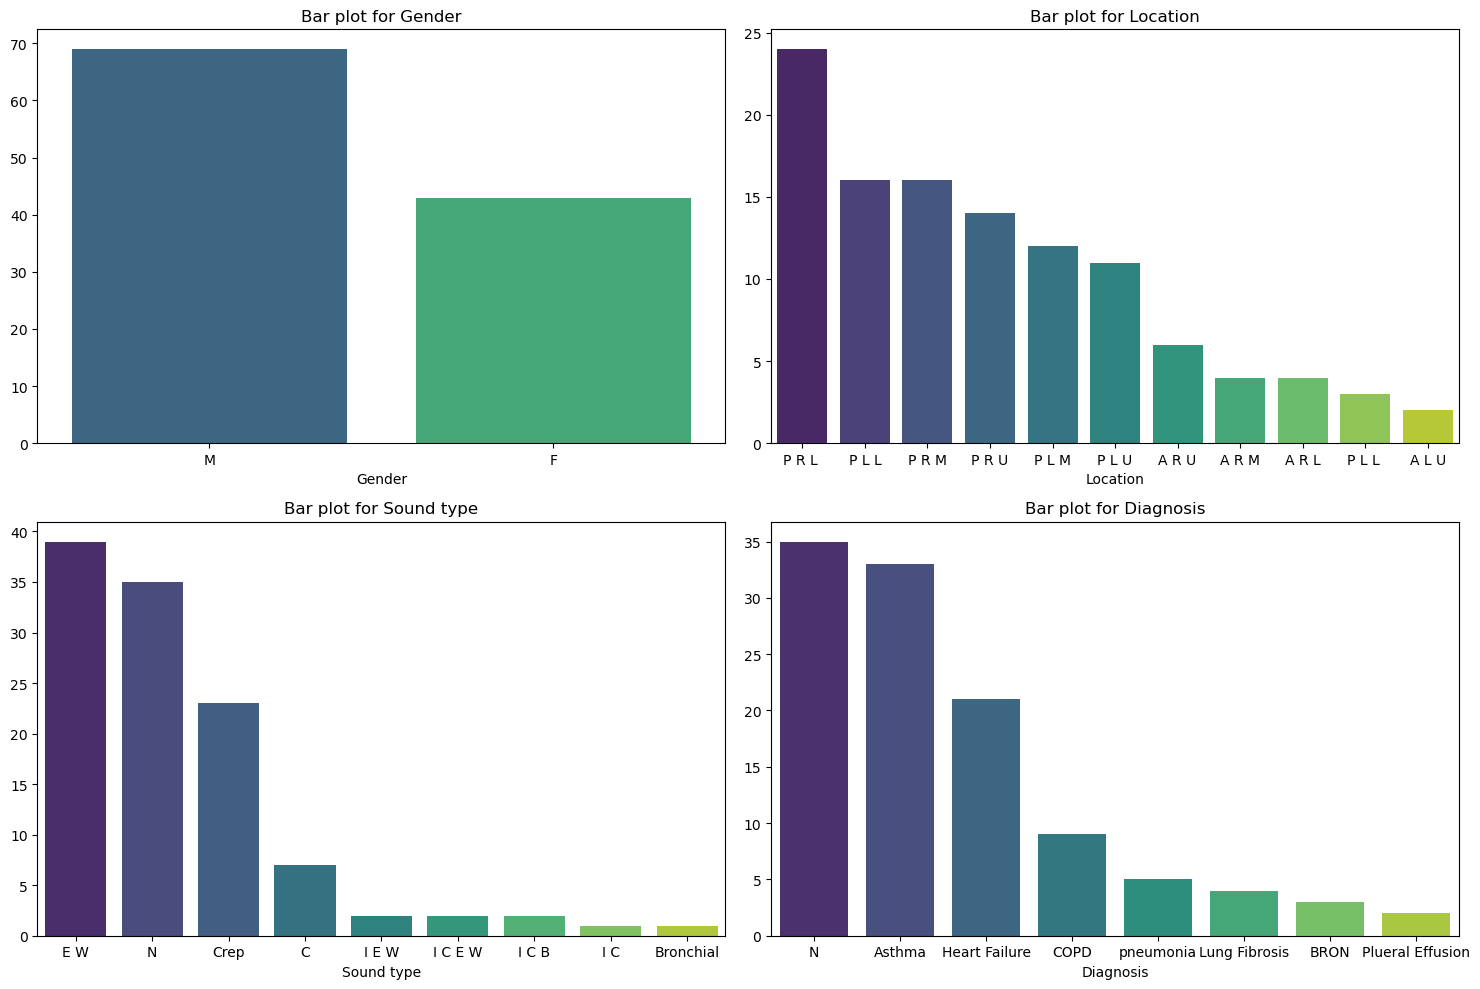

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, (key, value) in enumerate(count_dict.items()):
    sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
    axs[i//2, i%2].set_title(f'Bar plot for {key}')

plt.tight_layout()
plt.show()

The plot above shows the common pathologies are Asthma and Heart Failure, followed by COPD and pneumonia. The remaining pathologies will be difficult to classify isolately as there are no more samples to identify those. 

The common location are the Posterior (the six first quantities) and Lower (first two in terms of quantity) zones. Anterior Left Upper and Posterior Left Lower have the least samples. On the other hand, the most common sound are the Experiatory Wheezes and crepitations. The remaining noises could be non signinficant as the samples are less than ten.

As an initial strategy, we could only take the diagnosis, age, gender and the time series feature extraction as the main features of the problem. If necessary we can include the Sound and Location types. Even though the original paper took out the age to not bias the model.

### How many recordings do we have per condition?

Theoretically, the number of recordings is each count condition multiplied by each of the filters (Bell, Diaphragm and Extended), in other words:


In [11]:
count_dict['Diagnosis']*3

Diagnosis
N                   105
Asthma               99
Heart Failure        63
COPD                 27
pneumonia            15
Lung Fibrosis        12
BRON                  9
Plueral Effusion      6
Name: count, dtype: int64

## PART 2

This part focuses on signal processing and feature engineering, particularly in the context of audio or time-series data. Candidates may be asked to perform tasks like analyzing audio signals, visualizing data (e.g., waveforms), extracting relevant features (e.g., MFCC features), and explaining their significance.

- Explore and preprocess the acoustic dataset, including data cleaning, normalization, and feature engineering as needed.
- Conduct exploratory data analysis (EDA) to gain insights into the distribution and characteristics of the acoustic data.

### Describe the process you used to analyze the audio signals from the dataset. What specific characteristics did you examine, and what tools or libraries did you use for this analysis?

We will explore the different features available in the literature as Mel-frequency Cepstral Coefficients (MFCCs), Chroma, Spectral Contrast, Zero-Crossing rate and RMS energy. Moreover we will explore the features mentioned in the original paper as Shannon, Logarithmic and Spectral entropy.

It is our intention to filter such features with a feature importance analysis in order to reveal the importance of each feature.

We will use the most common library for audio pre-processing (Librosa) for python. I could also use the torchaudio library. However, the formar requires the data to be re-arranged. That is why we decided to use Librosa in this case.

Let us see the comparison between a healthy vs. an asmatic person.


/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


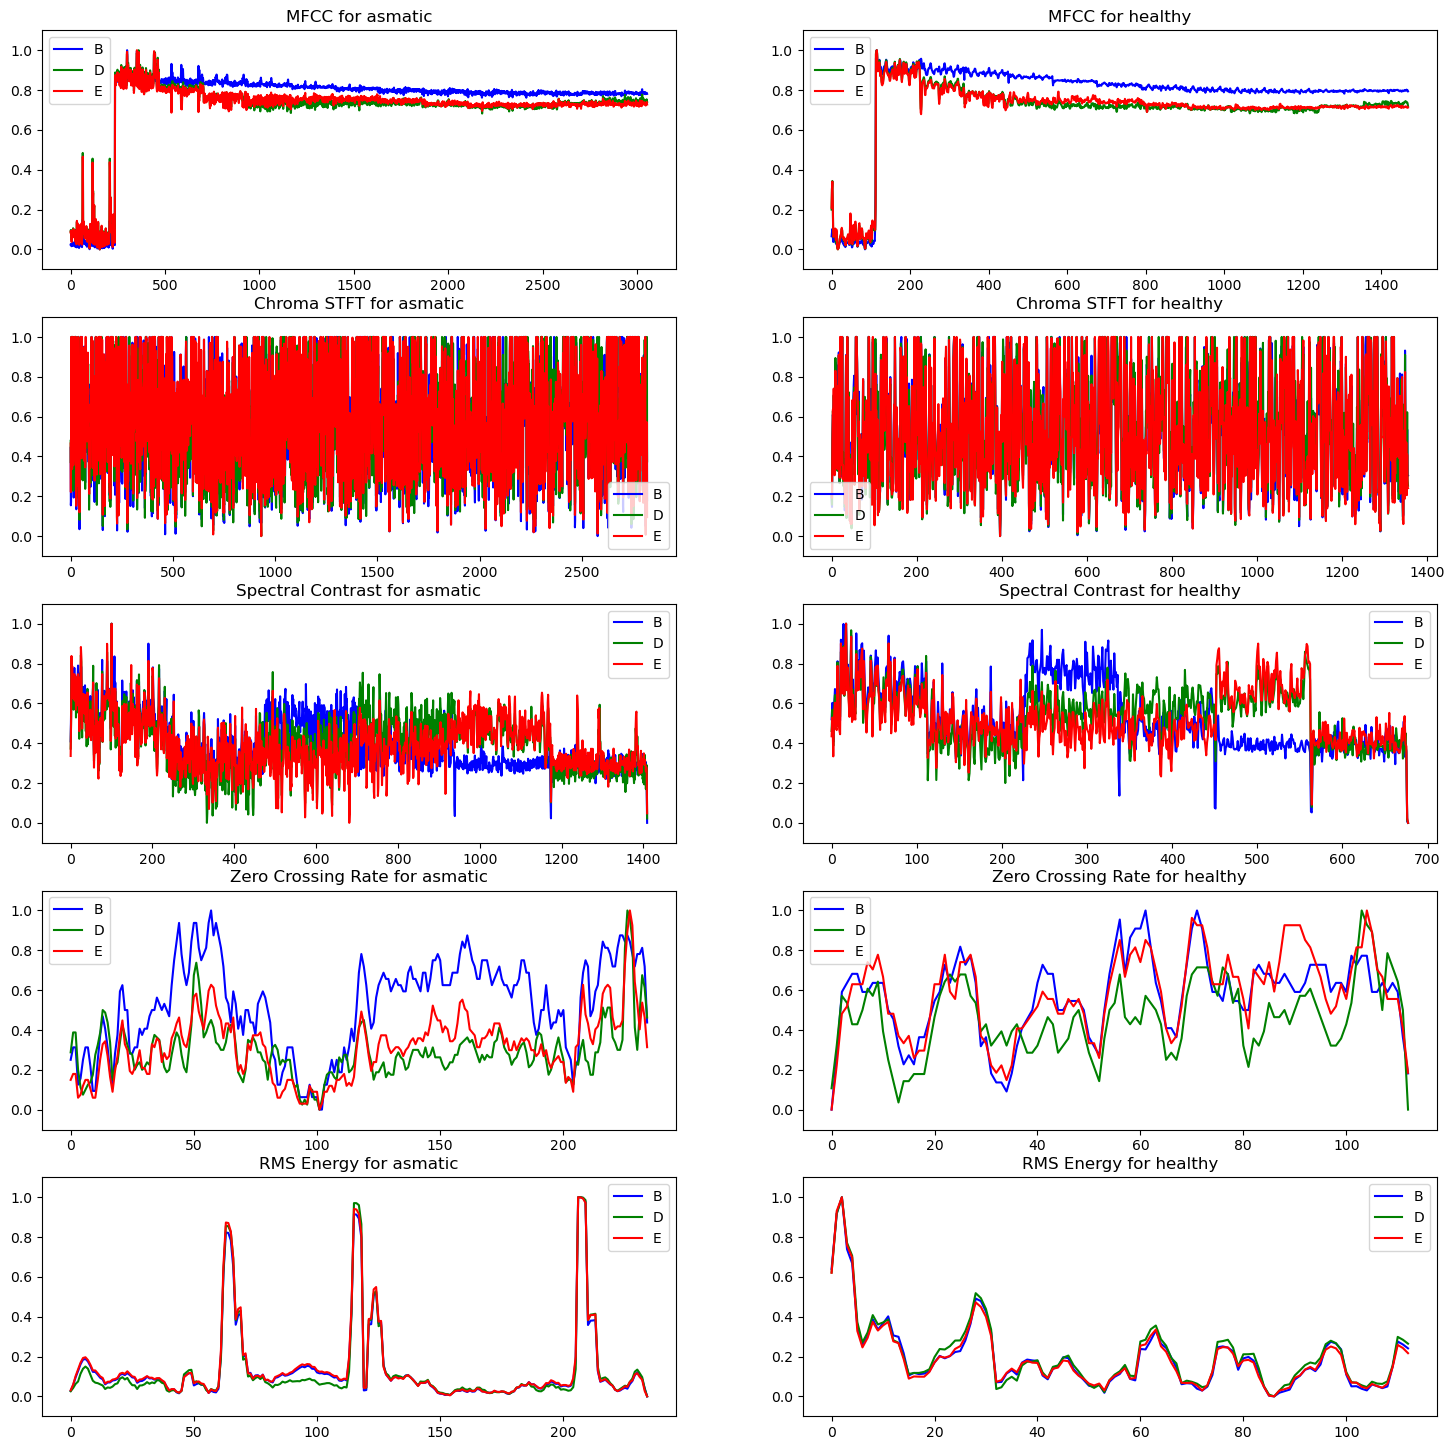

In [24]:
import librosa
from sklearn.preprocessing import MinMaxScaler

def extract_features(signal, sample_rate):
    signal = librosa.util.buf_to_float(signal, n_bytes=2)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
    chroma_stft = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    spec_contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate, n_bands=5, fmin=100.0)
    zero_crossing = librosa.feature.zero_crossing_rate(signal)
    rms = librosa.feature.rms(y=signal)
    
    return mfcc, chroma_stft, spec_contrast, zero_crossing, rms

fig, axs = plt.subplots(5, 2, figsize=(18, 18))

scaler = MinMaxScaler()

features = ['MFCC', 'Chroma STFT', 'Spectral Contrast', 'Zero Crossing Rate', 'RMS Energy']

for j, subject in enumerate(['asmatic', 'healthy']):
    for i, filter in enumerate(["B", "D", "E"]):
        sample_rate, sample_data = wavfile.read(audio_path + f'{filter}{post_fix[subject]}')
        feature_values = extract_features(sample_data, sample_rate)
        
        for k, (feature, title) in enumerate(zip(feature_values, features)):
            feature = scaler.fit_transform(feature.reshape(-1, 1))
            axs[k, j].plot(feature.mean(axis=1), color=colors[filter], label=filter)
            axs[k, j].legend()
            axs[k, j].set_title(f'{title} for {subject}')
            axs[k, j].set_ylim(-.1, 1.1)

Some observations about the plot above:

- **MFCCs**: The normalized MFCC plots still show a generally higher amplitude for the healthy subjects compared to the asthmatic subjects across most frequency bins.

- **Chroma STFT**: The normalized chroma STFT plots show similar trends to the normalized MFCC plots, with higher energy in most bins for the healthy subjects.

- **Spectral Contrast**: The normalized spectral contrast plots may show some slight differences between the asthmatic and healthy subjects that were not apparent in the non-normalized plots. However, the overall trend is still similar.

- **Zero Crossing Rate**: The normalized zero crossing rate plots still show a higher zero crossing rate for the healthy subjects compared to the asthmatic subjects across most time bins.

- **RMS Energy**: The normalized RMS energy plots may show some slight differences between the asthmatic and healthy subjects that were not apparent in the non-normalized plots. However, the overall trend is still similar, with higher energy for the healthy subjects.

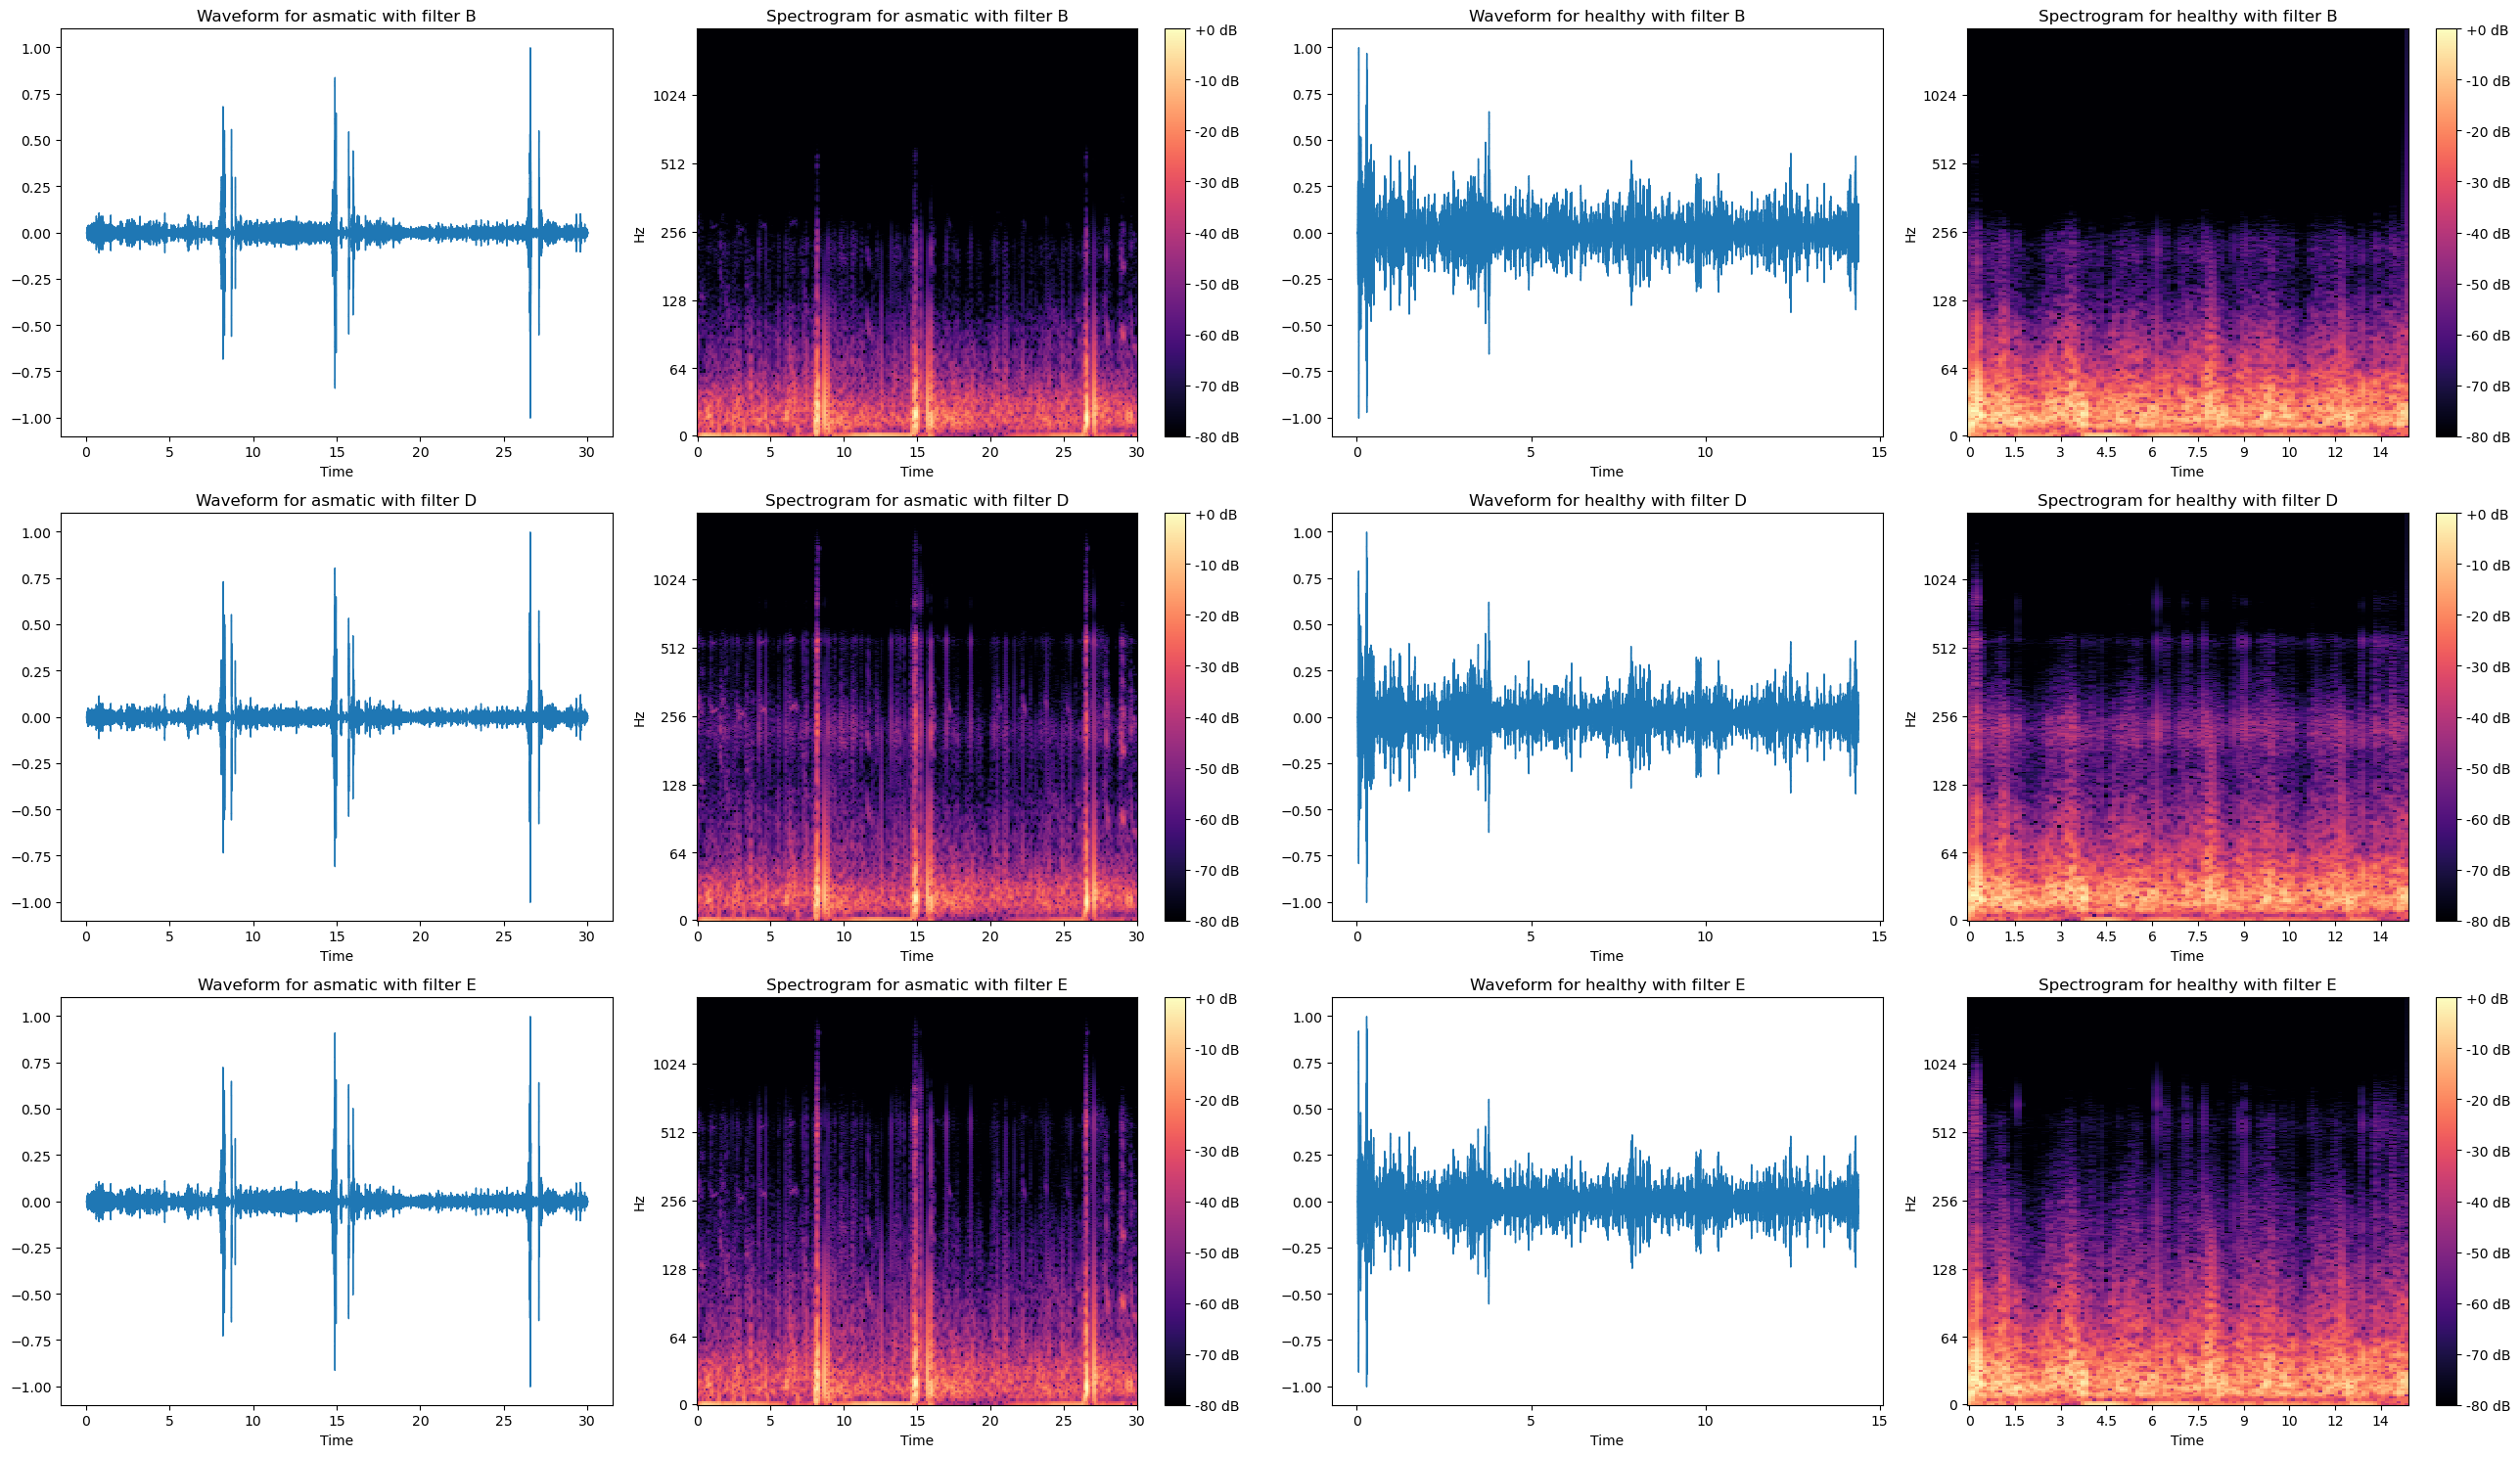

In [25]:
import librosa.display

subjects = ['asmatic', 'healthy']
filters = ["B", "D", "E"]

fig, axs = plt.subplots(len(filters), 2*len(subjects), figsize=(13*len(subjects), 5*len(filters)))

for i, filter in enumerate(filters):
    for j, subject in enumerate(subjects):
        sample_rate, sample_data = wavfile.read(audio_path + f'{filter}{post_fix[subject]}')
        
        sample_data = librosa.util.buf_to_float(sample_data, n_bytes=2)
        
        # Plot the waveform
        axs[i, j*2].set_title(f'Waveform for {subject} with filter {filter}')
        librosa.display.waveshow(sample_data, sr=sample_rate, ax=axs[i, j*2])
        
        # Compute and plot the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data)), ref=np.max)
        axs[i, j*2+1].set_title(f'Spectrogram for {subject} with filter {filter}')
        img = librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[i, j*2+1])
        fig.colorbar(img, ax=axs[i, j*2+1], format="%+2.f dB")

plt.tight_layout()
plt.show()

Preliminary observations conduct to a more amplitud in the wavesound for the healthy subjects and more changes in pressure in comparison with the Asmatic subjects. On the other hand, the spectograms reveals common patterns in the given filters: there are more presence of lighter areas in the healthy subjects, depicting more quieter sounds. The darker sounds are quiet higher also in the healthier population. 

## Setting up the dataset for training

After the preliminary analysis, let us take the results from the MFCCs coefficients, average them and normalize, for each of the represented given filters so that we can represent the data in a structured way:



In [212]:
data = []
file_names = []

audio_files = os.listdir(audio_path)

for file in audio_files:
    signal, sample_rate = librosa.load(os.path.join(audio_path, file), sr=None)    
    # Calculate the MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=26)
    # Average the MFCCs over time
    mfccs = np.mean(mfccs.T, axis=0)
    # Append the MFCCs to the data list
    data.append(mfccs)
    # Append the file name to the file_names list
    file_names.append(file)

# Create the DataFrame
df_mfcc = pd.DataFrame(data, index=file_names)
print(df_mfcc.shape)

(336, 26)


In [213]:
pattern = r'(?P<Filter>.*?)P(?P<SubjectNo>\d+)_(?P<Diagnosis>.*),(?P<SoundType>.*),(?P<Location>.*),(?P<Age>\d+),(?P<Gender>.*)\.wav'
features = df_mfcc.index.str.extract(pattern)
features

,Filter,SubjectNo,Diagnosis,SoundType,Location,Age,Gender
0,D,69,pneumonia,Bronchial,P R L,64,M
1,D,74,N,N,P R M,74,M
2,B,1,Asthma,I E W,P L L,70,M
3,B,65,asthma,E W,P R L,60,F
4,D,102,N,N,P L L,41,M
...,...,...,...,...,...,...,...
331,D,95,N,N,P L M,18,M
332,B,74,N,N,P R M,74,M
333,B,41,pneumonia,Crep,P R M,51,M
334,E,107,Asthma,E W,P L U,59,F


In [214]:
df_mfcc.reset_index(inplace=True)
df_mfcc = pd.concat([df_mfcc, features], axis=1)
df_mfcc.head(5)

,index,0,1,2,3,4,5,6,7,8,...,23,24,25,Filter,SubjectNo,Diagnosis,SoundType,Location,Age,Gender
0,"DP69_pneumonia,Bronchial,P R L ,64,M.wav",-363.189758,147.288788,50.159908,20.554222,16.811028,8.358005,8.155048,16.762056,12.082876,...,-1.665118,0.838467,1.605621,D,69,pneumonia,Bronchial,P R L,64,M
1,"DP74_N,N,P R M,74,M.wav",-409.999847,147.536545,86.255577,44.904961,26.350168,19.297718,20.898664,22.055399,12.505778,...,-1.167153,1.751054,1.890557,D,74,N,N,P R M,74,M
2,"BP1_Asthma,I E W,P L L,70,M.wav",-467.560852,59.107681,54.306721,47.637783,40.344215,33.265976,26.801960,21.193392,16.755501,...,-0.508983,-0.343663,0.029663,B,1,Asthma,I E W,P L L,70,M
3,"BP65_asthma,E W,P R L ,60,F.wav",-480.303833,77.443932,70.698380,61.366184,50.896404,40.561096,31.108404,23.011909,16.689636,...,-0.389538,0.069275,0.780145,B,65,asthma,E W,P R L,60,F
4,"DP102_N,N,P L L,41,M.wav",-383.303467,122.587669,72.118134,41.674419,26.838234,17.968445,16.886362,18.873499,12.901618,...,-2.320474,0.229173,0.914498,D,102,N,N,P L L,41,M


In [215]:
df_mfcc.set_index('SubjectNo', inplace=True)
df_mfcc.sort_index(inplace=True)
df_mfcc.head(5)

,index,0,1,2,3,4,5,6,7,8,...,22,23,24,25,Filter,Diagnosis,SoundType,Location,Age,Gender
SubjectNo,,,,,,,,,,,,,,,,,,,,,
1,"EP1_Asthma,I E W,P L L,70,M.wav",-423.757935,101.015106,55.433983,29.608803,23.280350,28.171272,28.258387,21.659948,12.149255,...,2.028385,2.835716,3.086576,2.581406,E,Asthma,I E W,P L L,70,M
1,"BP1_Asthma,I E W,P L L,70,M.wav",-467.560852,59.107681,54.306721,47.637783,40.344215,33.265976,26.801960,21.193392,16.755501,...,-0.258531,-0.508983,-0.343663,0.029663,B,Asthma,I E W,P L L,70,M
1,"DP1_Asthma,I E W,P L L,70,M.wav",-418.883240,107.852882,63.447548,32.256275,14.145453,12.413469,14.405203,14.977421,8.597672,...,-2.586542,-0.172546,2.286909,2.800446,D,Asthma,I E W,P L L,70,M
10,"BP10_Asthma,E W,P R U,59,M.wav",-389.127869,114.947113,93.163116,69.172310,48.657848,33.617619,22.008078,12.034925,4.401509,...,-3.330359,-2.766685,-1.147617,0.322180,B,Asthma,E W,P R U,59,M
10,"EP10_Asthma,E W,P R U,59,M.wav",-290.663879,186.453705,39.601536,5.155887,21.893978,34.785172,29.222218,15.420849,6.947412,...,0.198824,0.351354,0.603155,2.174452,E,Asthma,E W,P R U,59,M


In [216]:
df_mfcc.reset_index(inplace=True)
df_wide = df_mfcc.pivot(index='SubjectNo', columns='Filter')

# Flatten the multi-level column index
df_wide.columns = df_wide.columns.map('{0[0]}_{0[1]}'.format)

# Remove unnecessary index columns
df_wide = df_wide.loc[:, ~df_wide.columns.str.startswith('index')]

# Keep only one column for 'Diagnosis', 'SoundType', 'Location', 'Age', and 'Gender'
for col in ['Diagnosis', 'SoundType', 'Location', 'Age', 'Gender']:
    cols = [c for c in df_wide.columns if c.startswith(col)]
    df_wide[col] = df_wide[cols].bfill(axis=1).iloc[:, 0]
    df_wide = df_wide.drop(columns=cols[1:])

In [217]:
# Do not know why the B postfix was not removed
df_wide.drop(columns=[f'{label}_B' for label in ["Diagnosis", "SoundType","Location", "Age", "Gender"]], inplace=True)
# get rid of Age, Location, Gender, and SoundType
# df_wide.drop(columns= ["Age", "Location", "Gender", "SoundType"], inplace=True)
df_wide.drop(columns= ["Age"], inplace=True)

In [218]:
df_wide['Diagnosis'] = df_wide['Diagnosis'].replace(['Heart Failure + COPD', 
                    'Heart Failure + Lung Fibrosis ', 'heart failure'], 'Heart Failure')
df_wide['Diagnosis'] = df_wide['Diagnosis'].replace(['asthma','Asthma and lung fibrosis'], 'Asthma')
df_wide['Diagnosis'] = df_wide['Diagnosis'].replace('copd', 'COPD')
df_wide['Diagnosis'] = df_wide['Diagnosis'].replace(["BRON", "Plueral Effusion"], 'others')
# Exporting the data to a csv file
df_wide.to_csv('../dataset/processed_data.csv')
df_wide['Diagnosis'].value_counts()

Diagnosis
N                35
Asthma           33
Heart Failure    21
COPD              9
pneumonia         5
others            5
Lung Fibrosis     4
Name: count, dtype: int64

# Training the model

Let us keep things simple, let us perform the training process with the XGBoost algorithm, let us determine the hyperparameters with Bayesian optimization.

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()

# Define the features and the target
X = df_wide.drop(columns='Diagnosis')
# Transform the categorical variables
X['SoundType'] = le.fit_transform(X['SoundType'])
X['Location'] = le.fit_transform(X['Location'])
X['Gender'] = le.fit_transform(X['Gender'])
# Encode the target variable
y = le.fit_transform(df_wide['Diagnosis'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train

array([2, 2, 0, 2, 4, 0, 4, 2, 3, 0, 0, 2, 4, 1, 1, 0, 4, 3, 4, 2, 2, 4,
       0, 4, 0, 1, 6, 4, 0, 3, 4, 0, 4, 0, 1, 0, 6, 5, 4, 0, 2, 2, 4, 0,
       5, 4, 2, 1, 1, 0, 2, 4, 0, 2, 4, 2, 0, 0, 5, 2, 2, 2, 0, 6, 0, 4,
       0, 6, 4, 4, 0, 0, 4, 4, 0, 1, 2, 4])

### Resampling minority features

As a result of the iteration process, I realized that the minority samples in the set are causing the decrease of the performance. Let us try to oversampling the training set with the SMOTE algorithm

In [220]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

values, min_samples = np.unique(y_train, return_counts=True)

min_samples = min(min_samples)
sampling_strategy = {class_: 'not minority' for class_ in np.unique(y_train) if sum(y_train==class_) < min_samples}

resampler = Pipeline([
    ('smote', SMOTE(sampling_strategy=sampling_strategy, k_neighbors=min_samples-1)),
    ('ros', RandomOverSampler(sampling_strategy='not majority'))
])

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
print(X_train_resampled.shape, np.unique(y_train_resampled, return_counts=True)[1])


(161, 81) [23 23 23 23 23 23 23]


From now, we will tune the algorithm so that we can achieve the best performance in the model. the learning rate, max depth, min child weight and gamma will vary to obtain the best accuracy. As a metric let us shoose the logarithmic loss.

In [221]:
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

# Define the search space for the hyperparameters
search_space = {'max_depth': (3, 10),
                'gamma': (0, 1),
                'n_estimators': (10, 500),
                'learning_rate': (0, 1)}

# Define the cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize the Bayesian optimization object
opt = BayesSearchCV(xgb_clf, search_space, cv=cv, n_iter=15, random_state=42, 
                    n_jobs=-1, verbose=1)

# Resampling did not work here
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importa...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      objective='multi:softprob', ...),
              n_iter=15, n_jobs=-1, random_state=42,
              search_spaces={'gamma': (0, 1), 'learning_rate': (0, 1),
                             'max_depth': (3, 10), 'n_estimators': (10, 500)},
              verbose=1)

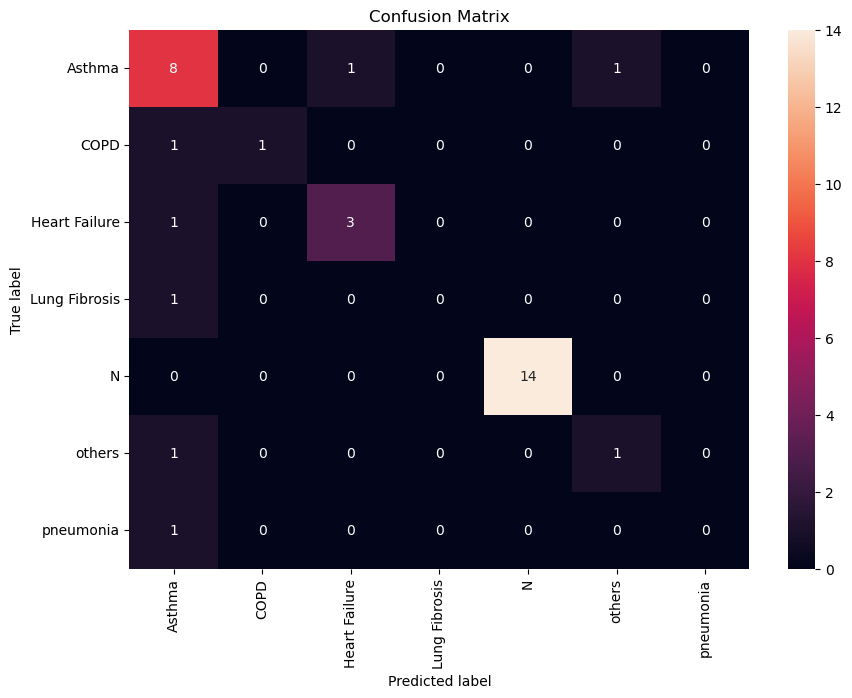

               precision    recall  f1-score   support

       Asthma       0.62      0.80      0.70        10
         COPD       1.00      0.50      0.67         2
Heart Failure       0.75      0.75      0.75         4
Lung Fibrosis       0.00      0.00      0.00         1
            N       1.00      1.00      1.00        14
       others       0.50      0.50      0.50         2
    pneumonia       0.00      0.00      0.00         1

     accuracy                           0.79        34
    macro avg       0.55      0.51      0.52        34
 weighted avg       0.77      0.79      0.77        34



/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nikorose/anaconda/envs/deeptools/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [222]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes on the test set
y_pred = opt.predict(X_test)

# Convert the encoded labels back to their original form
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(ticks=np.arange(len(le.classes_))+0.5, labels=le.classes_, rotation=90)
plt.yticks(ticks=np.arange(len(le.classes_))+0.5, labels=le.classes_, rotation=0)
plt.show()

# Print the classification report
print(classification_report(y_test_labels, y_pred_labels))

# Conclusions

- **More data is definitely needed**. Despite reducing the classes to five, extending the test set to 40 %, employing stratified k-fold cross-validation, and implementing other strategies, we were only able to achieve an accuracy of 0.78.

- **Competitors achieved slightly better performance (around 0.8) using deep neural networks** While this approach was considered, it was ultimately not pursued due to the limited dataset of only 112 subjects. Concatenating this data with the ICBHI dataset could potentially improve diagnosis, especially for COPD. The advantage of this method is that is less computationally complex and we are not so far from the benchmark.

- Other features, such as chroma or spectral features, may play a crucial role in classification. However, time constraints limited a thorough analysis of their importance.

- Improved documentation, particularly for the training section, is recommended. While some previously implemented techniques from past models were utilized, the process in this notebook is not fully explained.

Thanks for the opportunity. I will be very attentive for any news.